<a href="https://colab.research.google.com/github/hamish-haggerty/AI-hacking/blob/master/SSL/tune_hacking_cancer_maintrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# cancer_maintrain

> Please add a description. Don't forgot to edit the below cell!!

In [1]:
#| default_exp cancer_maintrain

Setup: Surely there is a way to get rid of having to put this cell everywhere. hmmm.

Or we can just copy paste / delete this in and out when needed. Either way, getting close to a decent workable workflow.

In [2]:
#| hide

def colab_is_true():

    try: 
        from google.colab import drive

        return True 
    except ModuleNotFoundError:
        return False

def setup_colab():
    import os
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    #os.system('unzip -q "/content/drive/My Drive/archive (1).zip"')
    os.system('git clone https://github.com/hamish-haggerty/cancer-proj.git')
    os.chdir('cancer-proj')
    os.system('unzip -q "/content/drive/My Drive/archive (1).zip"') #does this work?
    os.system('pip install -e .')
    os.system('pip install -qU nbdev')
    os.system('nbdev_install_quarto')

if __name__ == "__main__":
    on_colab = colab_is_true()
    if on_colab:
        setup_colab()

Mounted at /content/drive


In [3]:
#| hide

from nbdev.showdoc import *

In [4]:
#| export
from fastai.vision.all import *
#| export
from base_rbt.all import *
from cancer_proj.cancer_dataloading import *
from cancer_proj.cancer_metrics import *

In [5]:
def get_fnames_dict(train_dir,test_dir,class_names):
    "get dictionary of fnames"

        #files names
    fnames = get_image_files(train_dir)

    #Extract training set
    max_num =100 #maximum number of samples in each class
    count_dict = {i:0 for i in class_names}
    fnames_train = []
    for i in fnames:
        #st=extract_text(i.as_posix())
        st=label_func(i)
        
        if count_dict[st]<max_num: #no more than 100 samples per category
            fnames_train.append(i)
            count_dict[st]+=1
                    
    #We further partition fnames_train into a tune-valiation set
    count_dict2 = {i:0 for i in class_names}
    fnames_tune = []
    for i in fnames_train:
        st = label_func(i)
        if count_dict2[st] < 0.8*count_dict[st]:
            fnames_tune.append(i)
            count_dict2[st]+=1
            


    fnames_valid = get_difference(fnames_train,fnames_tune)

    fnames_test = get_difference(fnames,fnames_train) + get_image_files(test_dir)

    fnames_train = fnames_tune

    return {'fnames':fnames,'fnames_train':fnames_train,'fnames_tune':fnames_tune,
            'fnames_valid':fnames_valid,
            'fnames_test':fnames_test
            }

For now just get the data however it works. Will fix this later. But want to get `main_train` working for now

In [6]:
#| export

def get_fnames_dls_dict(train_dir,test_dir,
                        device,bs_val,bs=256,bs_tune=256,size=128,n_in=3,
                        ):

    "Wrapper that returns a dictionary with the fnames, dls etc"

    #do stuff

    class_names = get_file_lists(train_dir)['class_names']
    
    fnames_dict = get_fnames_dict(train_dir,test_dir,class_names)

    data_dict = get_data_dict(fnames_dict,train_dir,test_dir, #basic stuff needed
                  device,bs_val,bs=bs,bs_tune=bs_tune,size=size,n_in=n_in #hyperparameters
                 )

    d = {**fnames_dict,**data_dict}
    
    return d



## Load the data

In [7]:
#| hide

#Since we have cloned repository and cd'd into it (and the data itself is not stored in the
#repo) we need cd out of it, get the data, then cd back into the repo `cancer-proj`.
#This is a bit annoying, can maybe remove this later
if on_colab:
    #os.chdir('..') #assumes we are currently in cancer-proj directory
    train_dir = colab_train_dir
    test_dir = colab_test_dir
else:
    train_dir = local_train_dir
    test_dir = local_test_dir
    


#define general hps
device ='cuda' if torch.cuda.is_available() else 'cpu'
#bs=256
bs=698
bs_tune=256
size=128
bs_val=174

#get the data dictionary
data_dict = get_fnames_dls_dict(train_dir=train_dir,test_dir=test_dir,
                    device=device,bs_val=bs_val,bs=bs,bs_tune=bs_tune,size=size,n_in=3)

#get the dataloaders
dls_train,dls_tune,dls_valid = data_dict['dls_train'],data_dict['dls_tune'],data_dict['dls_valid']
x,y = data_dict['x'],data_dict['y']
xval,yval = data_dict['xval'],data_dict['yval']
xtune,ytune = data_dict['xtune'],data_dict['ytune']
vocab = data_dict['vocab']

#If we want to write some tests (make sure the data is same every time etc):
fnames,fnames_train,fnames_tune,fnames_valid,fnames_test = data_dict['fnames'],data_dict['fnames_train'],data_dict['fnames_tune'],data_dict['fnames_valid'],data_dict['fnames_test']

# if on_colab:
#     os.chdir('cancer-proj')

In [8]:
len(fnames_tune)

698

## Load aug pipelines here

In [9]:
#| hide


aug_dict = create_aug_pipelines(size=size,device=device,Augs=BYOL_Augs,TUNE_Augs=TUNE_Augs,Val_Augs=Val_Augs)
aug_pipelines = aug_dict['aug_pipelines']
aug_pipelines_tune = aug_dict['aug_pipelines_tune']
aug_pipelines_test = aug_dict['aug_pipelines_test'] 

In [10]:
xval.shape

torch.Size([174, 3, 128, 128])

In [11]:
#| hide
#show_bt_batch(dls=dls_train,aug=aug_pipelines,n_in=3)

In [12]:
#| hide

#show_linear_batch(dls=dls_tune,n_in=3,aug=aug_pipelines_tune,n=2,print_augs=True)

## TODO: Can probably put this in `dataloading`. No need to clog this notebook up.

In [13]:
#| hide

@patch
def lf(self:BarlowTwins, pred,*yb): return lf_bt(pred,I=self.I,lmb=self.lmb)

## main training api

In [14]:
#| hide

import itertools
initialweights = ['no_pretrain','supervised_pretrain']
fitpolicy = ['fit_one_cycle','fit']

#cartesian product of hps
MyTuple = namedtuple('MyTuple', 'initialweights fitpolicy')
HPs = [MyTuple(x,y) for x,y in list(itertools.product(initialweights, fitpolicy))]

for hp in HPs:
    print(hp.initialweights)

no_pretrain
no_pretrain
supervised_pretrain
supervised_pretrain


In [15]:
BYOL_Augs



{'flip_p1': 0.5,
 'flip_p2': 0.5,
 'jitter_p1': 0.8,
 'jitter_p2': 0.8,
 'bw_p1': 0.2,
 'bw_p2': 0.2,
 'blur_p1': 1.0,
 'blur_p2': 0.1,
 'sol_p1': 0.0,
 'sol_p2': 0.2,
 'noise_p1': 0.0,
 'noise_p2': 0.0,
 'resize_scale': (0.7, 1.0),
 'resize_ratio': (0.75, 1.3333333333333333),
 'rotate_deg': 45.0,
 'rotate_p': 0.5,
 'blur_r': (0.1, 2),
 'blur_s': 13,
 'sol_t': 0.1,
 'sol_a': 0.1,
 'noise_std': 0.1}

In [16]:
new_Augs = dict(BYOL_Augs)

In [17]:
create_aug_pipelines??

Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.0, 's': 13, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}
Pipeline: RandomResizedCrop -> RandomHorizontalFlip -> ColorJitter -> RandomGrayscale -> RandomGaussianNoise -> RandomGaussianBlur -- {'p': 1.0, 'prob': 0.0, 's': 13, 'sig': None, 'blur_r': (0.1, 2), 'same_on_batch': False} -> RandomSolarize -> Rotate -- {'size': None, 'mode': 'bilinear', 'pad_mode': 'reflection', 'mode_mask': 'nearest', 'align_corners': True, 'p': 1.0}


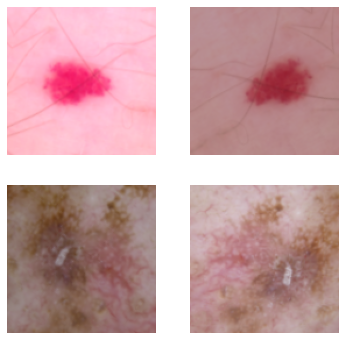

In [18]:
# new_Augs['jitter_p1']=0.
# new_Augs['jitter_p2']=0.

new_Augs['blur_p1']=0.0
new_Augs['blur_p2']=0.0

new_Augs['sol_p1']=0.0
new_Augs['sol_p2']=0.0

new_Augs['bw_p1']=0.0
new_Augs['bw_p2']=0.0

# new_Augs['rotate_p']=0.8
# new_Augs['rotate_deg'] = 90

new_aug_dict = create_aug_pipelines(size=size,device=device,Augs=new_Augs,TUNE_Augs=TUNE_Augs,Val_Augs=Val_Augs)
new_aug_pipelines = new_aug_dict['aug_pipelines']

show_bt_batch(dls=dls_train,aug=new_aug_pipelines,n_in=3)

In [55]:
def freeze_encoder(model):
    for param in model.encoder.parameters():
        param.requires_grad = False

def unfreeze_encoder(model):
    for param in model.encoder.parameters():
        param.requires_grad = True

In [56]:
def head_freeze_resnet(model):
    for param in model.encoder.encoder.parameters():

            param.requires_grad = False

def head_unfreeze_resnet(model):
    for param in model.encoder.encoder.parameters():

            param.requires_grad = True

In [57]:
def freeze_resnet(model):

    if model.model_type == 'res_proj': #means is resnet + projector
        freeze_encoder(model)

    elif model.model_type == 'res_head_proj': #means is resnet + head + projector
        head_freeze_resnet(model)

    elif model.model_type == 'res_linear': #means is resnet + linear_classifier
        freeze_encoder(model)

    elif model.model_type == 'res_head_linear': #means is resnet + head + linear_classifier

        head_freeze_resnet(model)

def unfreeze_resnet(model):

    if model.model_type == 'res_proj': #means is resnet + projector
        unfreeze_encoder(model)

    elif model.model_type == 'res_head_proj': #means is resnet + head + projector
        head_unfreeze_resnet(model)

    elif model.model_type == 'res_linear': #means is resnet + linear_classifier
        unfreeze_encoder(model)

    elif model.model_type == 'res_head_linear': #means is resnet + head + linear_classifier

        head_unfreeze_resnet(model)



In [58]:
def create_model(which_model,device,ps=8192,n_in=3):

    #pretrained=True if 'which_model' in ['bt_pretrain', 'supervised_pretrain'] else False

    if which_model == 'bt_pretrain': model = torch.hub.load('facebookresearch/barlowtwins:main', 'resnet50')
    
    elif which_model == 'no_pretrain': model = resnet50()

    elif which_model == 'supervised_pretrain': model = resnet50(weights='IMAGENET1K_V2')

    #ignore the 'pretrained=False' argument here. Just means we use the weights above 
    #(which themselves are either pretrained or not)
    encoder = get_resnet_encoder(model)

    model = create_barlow_twins_model(encoder, hidden_size=ps,projection_size=ps,nlayers=3)

    if device == 'cuda':
        model.cuda()
        encoder.cuda()


    return model,encoder

In [59]:
def create_model_head(which_model,device,ps=8192,n_in=3):

    #pretrained=True if 'which_model' in ['bt_pretrain', 'supervised_pretrain'] else False

    if which_model == 'bt_pretrain': model = torch.hub.load('facebookresearch/barlowtwins:main', 'resnet50')
    
    elif which_model == 'no_pretrain': model = resnet50()

    elif which_model == 'supervised_pretrain': model = resnet50(weights='IMAGENET1K_V2')

    #ignore the 'pretrained=False' argument here. Just means we use the weights above 
    #(which themselves are either pretrained or not)
    encoder = get_resnet_encoder(model)

    encoder = create_barlow_twins_model(encoder, hidden_size=2048,projection_size=2048,nlayers=2) #so one hidden layer...

    model = create_barlow_twins_model(encoder, hidden_size=ps,projection_size=ps,nlayers=2)
    

    if device == 'cuda':
        model.cuda()
        encoder.cuda()


    return model,encoder

In [60]:
@patch
@delegates(Learner.fit_one_cycle)
def fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    "Fine tune with `Learner.freeze` for `freeze_epochs`, then with `Learner.unfreeze` for `epochs`, using discriminative LR."
    self.freeze()
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)

In [61]:
@patch
@delegates(Learner.fit_one_cycle)
def resnet_fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    
    """Freeze resnet, tune non resnet layers, then unfreeze resnet and train as usual..."""

    #self.freeze()
    freeze_resnet(self.model)
    print('froze resnet')
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    #self.unfreeze()
    unfreeze_resnet(self.model)
    print('unfroze resnet')
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)

    #new_unfreeze_encoder(self.model)
    #print('unfroze encoder')

In [62]:
@patch
@delegates(Learner.fit_one_cycle)
def encoder_fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    
    """Freeze encoder, tune non encoder layers, then unfreeze encoder and train as usual... Note that
        encoder is either a resnet, or resnet+head"""

    
    # #self.freeze()
    freeze_encoder(self.model) #freeze head + resnet
    print('froze encoder')
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    #self.unfreeze()
    unfreeze_encoder(self.model) #unfreeze head + resnet
    print('unfroze encoder')
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)


    #new_unfreeze_encoder(self.model)
    #print('unfroze encoder')

In [63]:
x.shape

torch.Size([698, 3, 128, 128])

In [64]:
@patch
@delegates(Learner.fit_one_cycle)
def no_resnet_encoder_fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    
    """Freeze resnet whole way through"""

    
    #self.freeze()
    freeze_encoder(self.model) #freeze head + resnet
    print('froze encoder')
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    #self.unfreeze()
    unfreeze_encoder(self.model) 
    freeze_resnet(self.model)
    print('unfroze encoder, kept resnet frozen')
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)

    #new_unfreeze_encoder(self.model)
    #print('unfroze encoder')

In [65]:
@patch
@delegates(Learner.fit_one_cycle)
def no_resnet_fine_tune(self:Learner, epochs, base_lr=2e-3, freeze_epochs=1, lr_mult=100,
              pct_start=0.3, div=5.0, **kwargs):
    
    """Freeze resnet whole way through"""

    
    #self.freeze()
    freeze_resnet(self.model) #freeze head + resnet
    print('froze resnet')
    self.fit_one_cycle(freeze_epochs, slice(base_lr), pct_start=0.99, **kwargs)
    base_lr /= 2
    #self.unfreeze()
    self.fit_one_cycle(epochs, slice(base_lr/lr_mult, base_lr), pct_start=pct_start, div=div, **kwargs)

    unfreeze_resnet(self.model)
    print('unfroze resnet')

In [66]:
import gc
gc.collect()

3432

In [67]:
def freeze_upto_last_layer(model):
    "We freeze the last convolutional block. Not `exactly` the last layer, but kind of..."

    layers = list(model.children())
    N = len(layers)

    for p in model.parameters():
        p.requires_grad=False

    for p in layers[-3].parameters():
        p.requires_grad=True

def unfreeze_upto_last_layer(model):
    
    layers = list(model.children())
    N = len(layers)

    for p in model.parameters():
        p.requires_grad=True

    for p in layers[-3].parameters():
        p.requires_grad=True



In [68]:
def create_model_freeze(which_model,device,ps=8192,n_in=3):

    #pretrained=True if 'which_model' in ['bt_pretrain', 'supervised_pretrain'] else False

    if which_model == 'bt_pretrain': model = torch.hub.load('facebookresearch/barlowtwins:main', 'resnet50')
    
    elif which_model == 'no_pretrain': model = resnet50()

    elif which_model == 'supervised_pretrain': model = resnet50(weights='IMAGENET1K_V2')

    #ignore the 'pretrained=False' argument here. Just means we use the weights above 
    #(which themselves are either pretrained or not)
    encoder = get_resnet_encoder(model)

    freeze_upto_last_layer(encoder)

    model = create_barlow_twins_model(encoder, hidden_size=ps,projection_size=ps,nlayers=3)

    if device == 'cuda':
        model.cuda()
        encoder.cuda()


    return model,encoder

In [69]:
#| export

class main_train:
    """Instantiate and (optionally) train the encoder. Then fine-tune the supervised model. 
    Outputs metrics on validation data"""

    def __init__(self,
                 dls_train, #used for training BT (if pretrain=True)
                 dls_tune , #used for tuning
                 dls_valid, #used to compute metrics / evaluate results. 
                 xval, #currently `predict_model` below assumes this is entire validation / test data
                 yval,
                 aug_pipelines, #the aug pipeline for self-supervised learning
                 aug_pipelines_tune, #the aug pipeline for supervised learning
                 aug_pipelines_test, #test (or valid) time augmentations 
                 initial_weights, #Which initial weights to use
                 pretrain, #Whether to fit BT
                 fit_policy, #policy for fitting BT
                 tune_fit_policy,
                 num_epochs, #number of BT fit epochs
                 numfit, #number of tune_fit epochs
                 ps=8192, #projection size
                 n_in=3, #color channels
                 indim=2048, #dimension output of encoder (2048 for resnet50)
                 outdim=9, #number of classes
                 print_report=False, #F1 metrics etc
                 print_plot=False, #ROC curve
                 model_type='res_proj',
                 tune_model_type = 'res_linear'
                 ):
                 store_attr()
                 self.vocab = self.dls_valid.vocab

                 if self.model_type  == 'res_proj': test_ne(self.fit_policy,'no_resnet_encoder_fine_tune') #Doing this would make no sense


                 #if self.model_type == 'res_proj': test_eq(self.fit_policy,'resnet_fine_tune') #I THINK this is only viable option?

                 #self.encoder_path = f'/content/drive/My Drive/models/baselineencoder_initial_weights={self.initial_weights}_pretrain={self.pretrain}.pth'
                 #self.tuned_model_path = f'/content/drive/My Drive/models/baselinefinetuned_initial_weights={self.initial_weights}_pretrain={self.pretrain}.pth'

    @staticmethod
    def fit(learn,fit_policy,epochs):

        if fit_policy == 'fit':
            learn.fit(epochs)
        
        elif fit_policy == 'fit_one_cycle':
            learn.fit_one_cycle(epochs)
       
        elif fit_policy == 'fine_tune':

            learn.fine_tune(epochs,freeze_epochs=3,base_lr=0.01)

        elif fit_policy == 'resnet_fine_tune':
            learn.resnet_fine_tune(epochs,freeze_epochs=1)

        elif fit_policy == 'encoder_fine_tune':
            learn.encoder_fine_tune(epochs,freeze_epochs=100)

        elif fit_policy == 'no_resnet_encoder_fine_tune':
            learn.no_resnet_encoder_fine_tune(epochs,freeze_epochs=1)

        elif fit_policy == 'no_resnet_fine_tune':
            learn.no_resnet_fine_tune(epochs,freeze_epochs=1)

        else: raise Exception('Fit policy not of expected form')


    def train_encoder(self):
        "create encoder and (optionally, if pretrain=True) train with BT algorith, according to fit_policy"

        if self.model_type == 'res_proj':

            bt_model,encoder = create_model(which_model=self.initial_weights,device=device) #resnet + projector

            #bt_model,encoder = create_model_freeze(which_model=self.initial_weights,device=device)

            bt_model.model_type=self.model_type

        # elif self.model_type == 'res_head_proj':
        #     bt_model,encoder = create_model_head(which_model=self.initial_weights,device=device) #resnet + head + projector
        #     bt_model.model_type=self.model_type

        if self.pretrain: #train encoder according to fit policy

            
            learn = Learner(self.dls_train,bt_model, cbs=[BarlowTwins(self.aug_pipelines,n_in=self.n_in,lmb=1/self.ps,print_augs=False)])

            main_train.fit(learn,self.fit_policy,epochs=self.num_epochs)

            #torch.save(encoder.state_dict(), self.encoder_path)

        self.encoder = bt_model.encoder


    def fine_tune(self):
        "fine tune in supervised fashion, according to tune_fit_policy"

        #encoder = pickle.loads(pickle.dumps(self.encoder)) #We might want to pretrain once and fine tune several times (varying e.g. tune augs)

        model = LinearModel(encoder=self.encoder,indim=self.indim,outdim=self.outdim) #create 'linear' model (encoder + linear head)
        
        model.model_type = self.tune_model_type

        learn = Learner(self.dls_tune,model,cbs = [LinearBt(aug_pipelines=self.aug_pipelines_tune,n_in=self.n_in)],wd=0.0)

        main_train.fit(learn,fit_policy=self.tune_fit_policy,epochs=self.numfit) #fine tuning (don't confuse this with fit policy!)

        scores,preds, acc = predict_model(self.xval,self.yval,model=model,aug_pipelines_test=self.aug_pipelines_test,numavg=3)

        #metrics dict will have f1 score, auc etc etc
        metrics = classification_report_wrapper(preds, self.yval, self.vocab, print_report=self.print_report)
        metrics['acc'] = acc
        auc_dict = plot_roc(self.yval,preds,self.vocab,print_plot=self.print_plot)
        metrics['auc_dict'] = auc_dict

        metrics['scores'] = scores
        metrics['preds'] = preds
        
        #torch.save(model.state_dict(), self.tuned_model_path)
        return metrics #

    def __call__(self):

        self.train_encoder() #train (or extract) the encoder
        metrics = self.fine_tune()
        
        return metrics

if __name__ == '__main__' and on_colab:
    torch.cuda.empty_cache()


    # initialweights = ['bt_pretrain','supervised_pretrain']
    # fitpolicy = ['fit_one_cycle','fit']

    # #cartesian product of hps
    # MyTuple = namedtuple('MyTuple', 'initialweights fitpolicy')
    # HPs = [MyTuple(x,y) for x,y in list(itertools.product(initialweights, fitpolicy))]


    # for _ in range(1):

    #     d={}
    #     for initial_weights in initialweights:
    #         metrics = main_train(dls_train=dls_train,dls_tune=dls_tune,dls_valid=dls_valid, xval=xval, yval=yval,
    #             aug_pipelines=aug_pipelines, aug_pipelines_tune=aug_pipelines_tune, aug_pipelines_test=aug_pipelines_test, 
    #             initial_weights='supervised_pretrain',pretrain=True,fit_policy='fit',tune_fit_policy='fine_tune',num_epochs=20,numfit=20, 
    #             )()

    #         d[initial_weights] = {}

    #         d[initial_weights]['acc'] = metrics['acc']

    #         d[initial_weights]['scores'] = metrics['scores']

    #         print(f"With initial_weights={initial_weights}, acc is {d[initial_weights]['acc']}")


    #     ypred,acc = predict_ensemble(yval,scores1=d['bt_pretrain']['scores'],scores2=d['supervised_pretrain']['scores'])

    #     print(f'Acc of ensemble is {acc}')



    aug_dict = create_aug_pipelines(size=size,device=device,Augs=BYOL_Augs,TUNE_Augs=TUNE_Augs,Val_Augs=Val_Augs)
    aug_pipelines = aug_dict['aug_pipelines']
    aug_pipelines_tune = aug_dict['aug_pipelines_tune']
    aug_pipelines_test = aug_dict['aug_pipelines_test'] 


    num=1
    mean_acc = 0.0
    numfit=50

    for _ in range(num):
        main = main_train(dls_train=dls_tune,dls_tune=dls_tune,dls_valid=dls_valid, xval=xval, yval=yval,
                    aug_pipelines=aug_pipelines, aug_pipelines_tune=aug_pipelines_tune, aug_pipelines_test=aug_pipelines_test, 
                    initial_weights='bt_pretrain',pretrain=True,fit_policy='encoder_fine_tune',tune_fit_policy='fine_tune',num_epochs=500,numfit=numfit,
                    model_type='res_proj',
                    tune_model_type='res_linear',
                    print_report=True,
                    ps=8192
                        )
        
        metrics = main()

        acc = metrics['acc']
        print(acc)
        mean_acc += acc

    print(mean_acc/num)

    print(f'bt pretrain numfit={numfit}')
    print('replaced create_model with create_model_freeze. i.e. freeze up to last layer...')
    print('edited encoder_fine_tune to use `fit` instead with small learning rate...')
    print('no projector')
  

    del main
    torch.cuda.empty_cache()


Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


froze encoder


epoch,train_loss,valid_loss,time
0,4933.644531,None,00:06
1,5214.287598,None,00:06
2,5168.447266,None,00:06
3,4722.270996,None,00:06
4,4350.373047,None,00:06
5,4043.295410,None,00:06
6,3777.969727,None,00:06
7,3579.505859,None,00:06
8,3411.158203,None,00:06
9,3244.218262,None,00:06


/usr/local/lib/python3.8/dist-packages/fastprogress/fastprogress.py:73: UserWarning: Your generator is empty.
  warn("Your generator is empty.")


unfroze encoder


epoch,train_loss,valid_loss,time
0,453.986023,None,00:06
1,468.732971,None,00:06
2,454.763336,None,00:06
3,445.968872,None,00:07
4,444.296997,None,00:07
5,439.927246,None,00:06
6,438.586395,None,00:07
7,439.539795,None,00:07
8,437.330475,None,00:06
9,438.136047,None,00:06


epoch,train_loss,valid_loss,time
0,2.199473,None,00:06
1,2.181591,None,00:06
2,2.125243,None,00:07


epoch,train_loss,valid_loss,time
0,1.817262,None,00:06
1,1.762934,None,00:07
2,1.706654,None,00:06
3,1.636351,None,00:06
4,1.567635,None,00:06
5,1.493152,None,00:06
6,1.417586,None,00:07


epoch,train_loss,valid_loss,time
0,1.817262,None,00:06
1,1.762934,None,00:07
2,1.706654,None,00:06
3,1.636351,None,00:06
4,1.567635,None,00:06
5,1.493152,None,00:06
6,1.417586,None,00:07
7,1.346281,None,00:06
8,1.275067,None,00:06
9,1.198939,None,00:07


                            precision    recall  f1-score   support

         actinic keratosis       0.57      0.80      0.67        20
      basal cell carcinoma       0.61      0.55      0.58        20
            dermatofibroma       0.95      0.95      0.95        19
                  melanoma       0.50      0.50      0.50        20
                     nevus       0.40      0.30      0.34        20
pigmented benign keratosis       0.60      0.75      0.67        20
      seborrheic keratosis       0.58      0.47      0.52        15
   squamous cell carcinoma       0.71      0.50      0.59        20
           vascular lesion       0.78      0.90      0.84        20

                  accuracy                           0.64       174
                 macro avg       0.63      0.63      0.63       174
              weighted avg       0.63      0.64      0.63       174

0.6379310488700867
0.6379310488700867
bt pretrain numfit=50
replaced create_model with create_model_freeze. i.e. 

In [70]:
0.6551724076271057
0.6551724076271057
bt pretrain numfit=50
replaced create_model with create_model_freeze. i.e. freeze up to last layer...
edited encoder_fine_tune to use `fit` instead 


0.5919539928436279
0.5919539928436279
bt pretrain numfit=50
replaced create_model with create_model_freeze. i.e. freeze up to last layer...
edited encoder_fine_tune to use `fit` instead

SyntaxError: ignored

In [ ]:
from statistics import mean

In [ ]:
mean([0.59,0.60919,0.597701,0.614942,0.58620]) #baseline with no pre-pre training...

In [ ]:
del main

In [ ]:
num_epochs=20

0.6724137663841248
0.6724137663841248
base augs + jitter

0.6954023241996765
0.6954023241996765
base augs + jitter

0.6494252681732178
0.6494252681732178
base augs + jitter



0.6551724076271057
0.6551724076271057
base augs + jitter + num_epochs=100

In [ ]:
#Only base augs. Melanoma sucked. 
metrics1


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()